In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import imgaug

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
data_dir = root_dir / "Data"
log_dir = root_dir / "Logs"
saved_model_dir = root_dir / "SavedModel"

# Import the configuration associated with this dataset and network.
config = maskflow.load_config(root_dir / "config.yml")

Using TensorFlow backend.


# Load Training Dataset

In [3]:
# Split dataset
fnames = list((data_dir / "Image").glob("*.tif"))
#fnames = np.random.choice(fnames, 50)
train_fnames, validation_fnames = train_test_split(fnames, test_size=0.25)

# Build dataset
dataset_train = maskflow.MaskflowDataset()
dataset_train.set_dataset(train_fnames, config["CLASS_NAMES"])

dataset_val = maskflow.MaskflowDataset()
dataset_val.set_dataset(validation_fnames, config["CLASS_NAMES"])

print(f"train_fnames : {len(train_fnames)} | validation_fnames : {len(validation_fnames)}")

train_fnames : 1081 | validation_fnames : 361


{'id': 256, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/image_snr_3.1_n-mts_110_id_25.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/image_snr_3.1_n-mts_110_id_25.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/image_snr_3.1_n-mts_110_id_25.csv')}


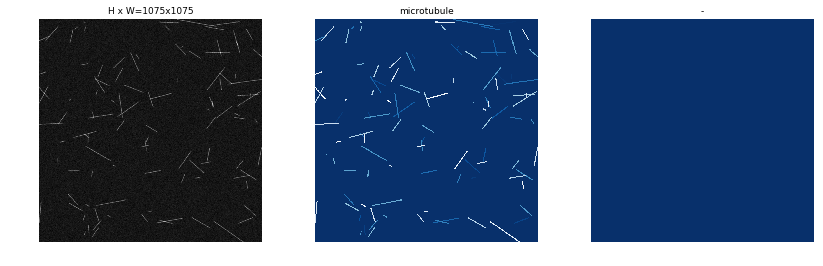

{'id': 880, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/image_snr_3.1_n-mts_110_id_33.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/image_snr_3.1_n-mts_110_id_33.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/image_snr_3.1_n-mts_110_id_33.csv')}


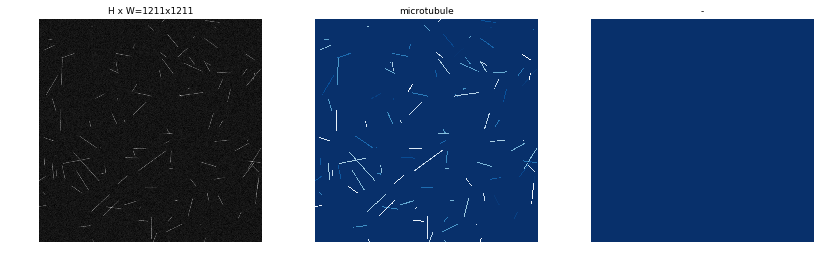

In [5]:
dataset_train.random_display(n=2, n_class=2)

# Training

In [11]:
maskflow_config = maskflow.MaskflowConfig(config)

maskflow_config.IMAGES_PER_GPU = 6
maskflow_config.GPU_COUNT = 1
maskflow_config.STEPS_PER_EPOCH = 200

maskflow_config.update()
maskflow_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1, 0.1, 0.2, 0.2]
CLASS_NAMES                    ['microtubule']
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 6
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  100
IMAGE_MIN_SCALE                1
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MAX_OBJECTS                    200
MEAN_PIXEL                     [123.7, 116.8, 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                  

In [12]:
model = maskflow.load_model(log_dir, maskflow_config, mode="training")

maskflow.load_weights(model, init_with="coco")

# Copy config file to log directory
maskflow.save_config(config, Path(model.log_dir) / "config.yml")

In [13]:
model.train(dataset_train, dataset_val,
            learning_rate=maskflow_config.LEARNING_RATE,
            epochs=200, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/microtubule_detector20180624T1533/mask_rcnn_microtubule_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDist

/home/hadim/conda/envs/nn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hadim/conda/envs/nn/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/200
 39/200 [====>.........................] - ETA: 35:08 - loss: 2.4726 - rpn_class_loss: 0.3642 - rpn_bbox_loss: 0.6122 - mrcnn_class_loss: 0.5051 - mrcnn_bbox_loss: 0.4552 - mrcnn_mask_loss: 0.5359

KeyboardInterrupt: 

start: 11h35

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=maskflow_config.LEARNING_RATE,
            epochs=200, layers='all')

# Load Trained Model

In [4]:
training_name = "shapes_detector20180621T0950"

maskflow_config = maskflow.MaskflowConfig(config)
maskflow_config.IMAGES_PER_GPU = 1
maskflow_config.GPU_COUNT = 1
maskflow_config.update()

model = maskflow.load_model(log_dir, maskflow_config, mode="inference")
maskflow.load_weights(model, init_with=training_name)

# Load image with true predictions

{'id': 99, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Shapes/Data/Image/toy_0305.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Shapes/Data/Mask/toy_0305.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Shapes/Data/Class/toy_0305.csv')}


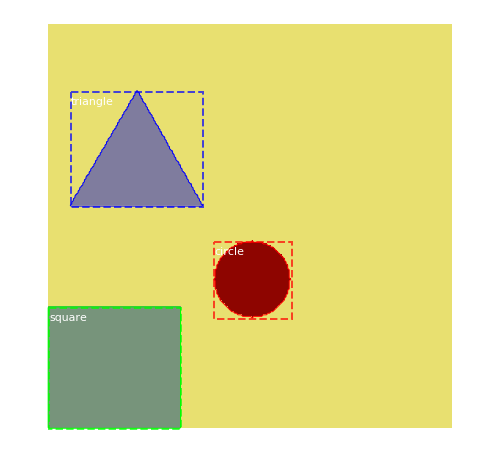

In [12]:
# Load a random image
image_id = np.random.choice(dataset_val.image_ids)
#image_id = 99

print(dataset_val.image_info[image_id])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = maskflow.load_image_gt(dataset_val,
                                                                                   maskflow_config,
                                                                                   image_id,
                                                                                   use_mini_mask=False)

maskflow.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

# Predict

In [13]:
results = maskflow.predict(original_image, model, progress=True, verbose=0)

masked_images = maskflow.draw_results(original_image, results, model.config.CLASS_NAMES, colors=None, resize_ratio=1, draw_boxes=True, draw_masks=True, draw_contours=True, draw_score=True)
maskflow.show_images([[original_image], masked_images], size=10)

100%|██████████| 1/1 [00:00<00:00, 129.95it/s]


interactive(children=(IntSlider(value=0, description='t', max=0), Output()), _dom_classes=('widget-interact',)…

# Export trained model to ZIP

In [ ]:
model_name = "good_one"
maskflow.export_to_zip(model, model_name, saved_model_dir)